# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [x] (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [118]:
from numbers import Integral

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_scalar
from sklearn.utils.multiclass import check_classification_targets

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Чтение данных

In [119]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак target имеет ли пациент заболевание сердца.

# EDA

Посмотрим сколько людей страдают заболеванием сердца и сколько нет.

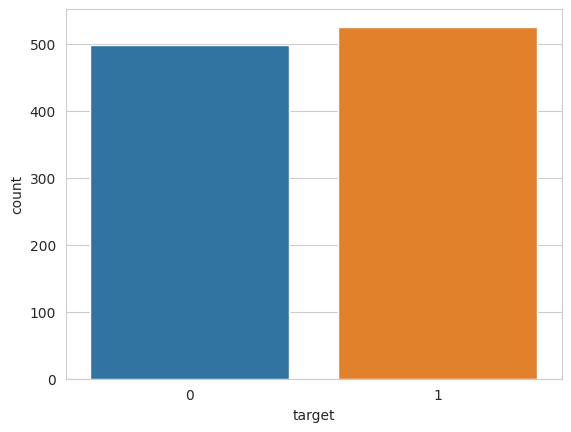

In [120]:
sns.countplot(x="target", data=df)
plt.show()

Посмотрим, нет ли пропущенных значений.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Посмотрим на распределение параметров.

In [122]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


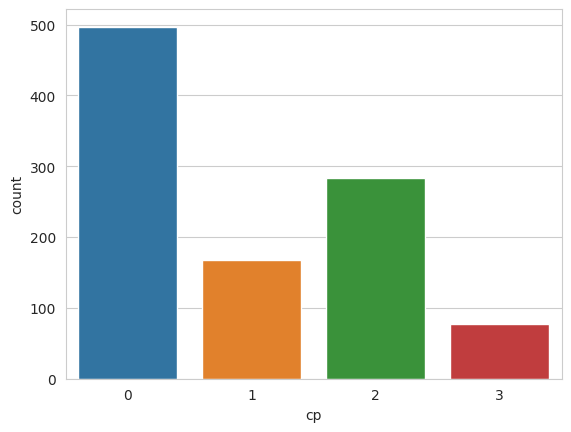

In [123]:
sns.countplot(x="cp", data=df)
plt.show()

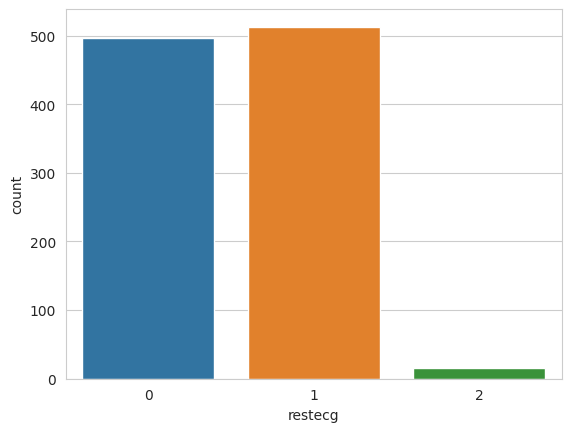

In [124]:
sns.countplot(x="restecg", data=df)
plt.show()

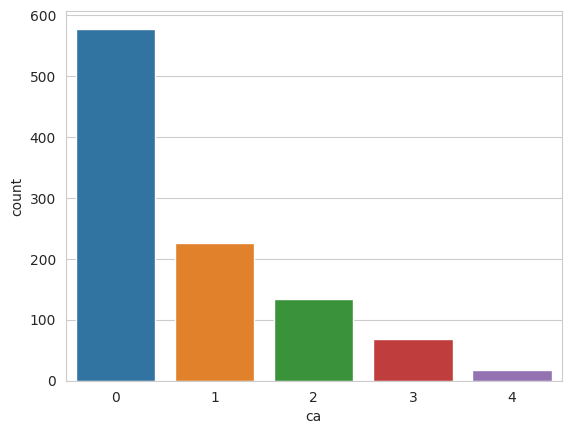

In [125]:
sns.countplot(x="ca", data=df)
plt.show()

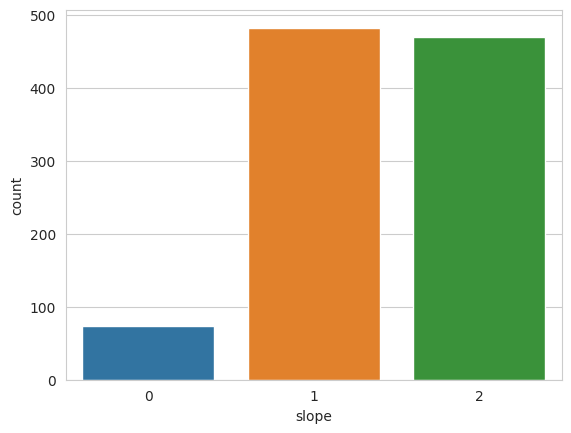

In [126]:
sns.countplot(x="slope", data=df)
plt.show()

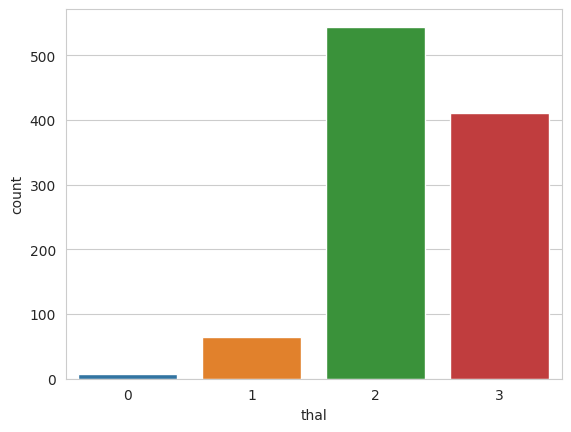

In [127]:
sns.countplot(x="thal", data=df)
plt.show()

Посмотрим на зависимость заболевания сердца и возраста.

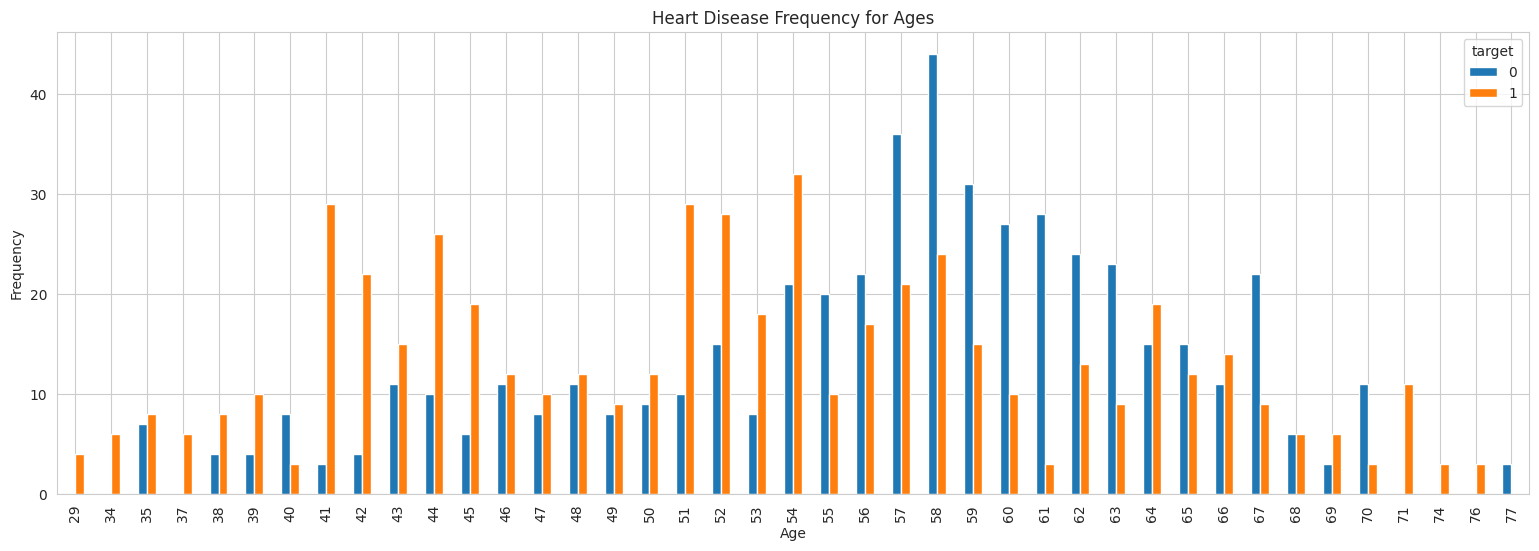

In [128]:
pd.crosstab(df.age, df.target).plot(kind="bar", figsize=(19, 6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

Можно видеть, что в данной выборке в возрасте примерно до 54 лет, больше вероятность быть с больным сердцем, нежели со здоровым.

Посмотрим есть ли какая то разница между мужчинами и женщинами по частоте заболевания сердца.

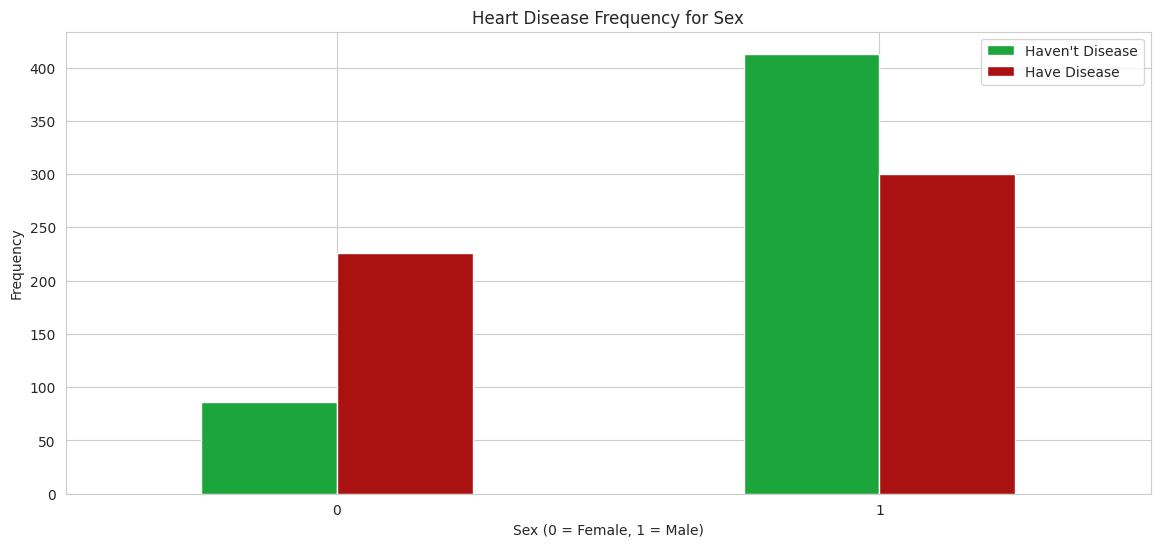

In [129]:
pd.crosstab(df.sex,df.target).plot(kind="bar", figsize=(14, 6), color=['#1CA53B', '#AA1111' ])
plt.title('Heart Disease Frequency for Sex')
plt.xlabel('Sex (0 = Female, 1 = Male)')
plt.xticks(rotation=0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

Можно видеть, что у женщин больше вероятность быть с больным сердцем.

Посмотрим на зависимость возраста от максимального пульса у больных и не больных людей.

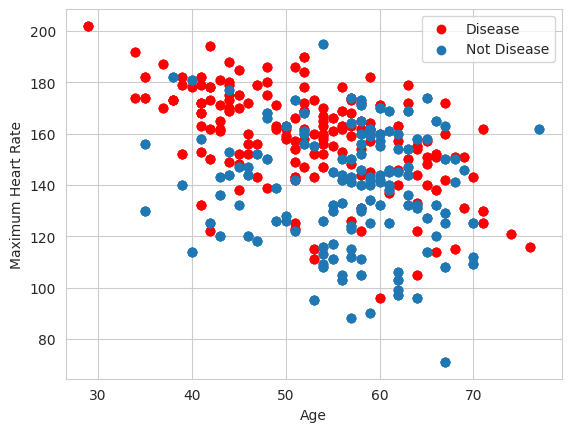

In [130]:
plt.scatter(x=df.age[df.target==1], y=df.thalach[(df.target==1)], c="red")
plt.scatter(x=df.age[df.target==0], y=df.thalach[(df.target==0)])
plt.legend(["Disease", "Not Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

Можно увидеть отрицательную корреляцию между возрастом и максимальной частотой сердцебиения у людей, которые больны.

Посмотрим на матрицу коррелции.

<Axes: >

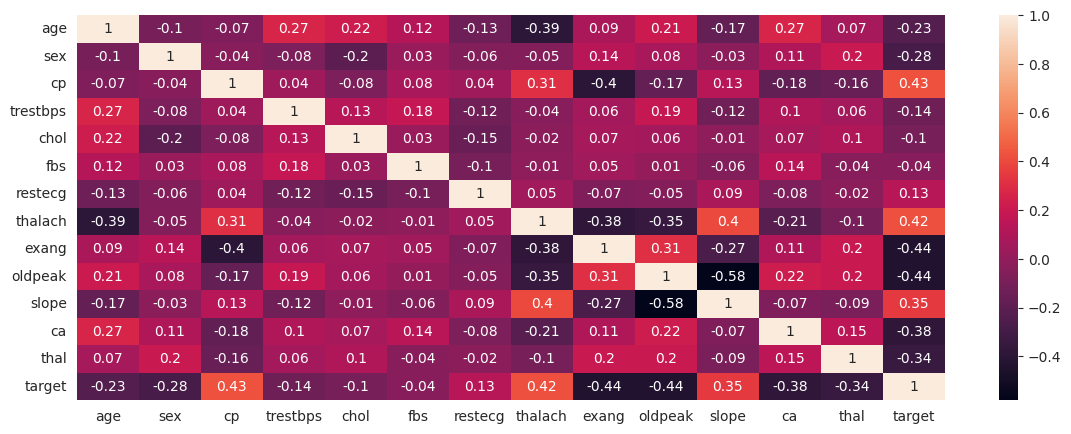

In [131]:
plt.figure(figsize = (14,5))
sns.heatmap(round(df.corr(), 2), annot=True)

# Преобразование категориальных признаков

Закодируем категориальные признаки cp, restecg, ca, thal и slope.

In [132]:
cp_dum = pd.get_dummies(df['cp'], prefix = "cp")
restecg_dum = pd.get_dummies(df['restecg'], prefix = "restecg")
ca_dum = pd.get_dummies(df['ca'], prefix = "ca")
thal_dum = pd.get_dummies(df['thal'], prefix = "thal")
slope_dum = pd.get_dummies(df['slope'], prefix = "slope")

frames = [df, cp_dum, restecg_dum, ca_dum, thal_dum, slope_dum]
df = pd.concat(frames, axis = 1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,0,125,212,0,1,168,0,1.0,...,1,0,0,0,0,0,1,0,0,1
1,53,1,0,140,203,1,0,155,1,3.1,...,0,0,0,0,0,0,1,1,0,0
2,70,1,0,145,174,0,1,125,1,2.6,...,0,0,0,0,0,0,1,1,0,0
3,61,1,0,148,203,0,1,161,0,0.0,...,0,0,0,0,0,0,1,0,0,1
4,62,0,0,138,294,1,1,106,0,1.9,...,0,1,0,0,0,1,0,0,1,0


In [133]:
df = df.drop(columns = ['cp', 'restecg', 'ca', 'thal', 'slope'])
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,target,cp_0,...,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,168,0,1.0,0,1,...,1,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,155,1,3.1,0,1,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,125,1,2.6,0,1,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,161,0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,106,0,1.9,0,1,...,0,1,0,0,0,1,0,0,1,0


# Реализация своего метода

## Реализация метода Support Vector Machine (SVM)

In [134]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=1000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            if y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Реализация метода K-Nearest Neighbour (k-NN)

In [135]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors: Integral = 3):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.n_neighbors = check_scalar(self.n_neighbors, "n_neighbors", Integral, min_val=1)
        self.X_, self.y_ = check_X_y(X, y)
        check_classification_targets(self.y_)
        self.n_features_in_ = self.X_.shape[1]
        self.classes_ = np.unique(self.y_)
        return self

    def _find_commonest(arr):
        elems, counts = np.unique(arr, return_counts=True)
        return elems[np.argmax(counts)]

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        result = np.empty((X.shape[0],), dtype=self.y_.dtype)
        for i, x in enumerate(X):
            dists = np.linalg.norm(self.X_ - x, axis=1)
            sorted_dists_idx = np.argsort(dists)
            neighbor_classes = self.y_[sorted_dists_idx][:self.n_neighbors]
            result[i] = KNNClassifier._find_commonest(neighbor_classes)
        return result

    def get_params(self, deep=True):
        return {"n_neighbors": self.n_neighbors}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

# Разбиение данных с использованием train_test_split и масштабирование

In [136]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

scaler = StandardScaler()  # воспользуемся стандартным трансформером

# масштабируем обучающую выборку и запоминаем среднее, стандартное отклонение признаков
X_train_scaled = scaler.fit_transform(X_train)

# масштабируем тестовую выборку используя статистики обучающей выборки
X_test_scaled = scaler.transform(X_test)

# Подбор наилучших признаков

In [137]:
rfecv = RFECV(estimator=LogisticRegression())
rfecv.fit(X_train, y_train)
features = list(X_train.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Оптимальные признаки: ", features)
print("Общее кол-во признаков", (X_train.shape)[1])
X_train.info()

Оптимальное число признаков:  26
Оптимальные признаки:  ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'cp_0', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2']
Общее кол-во признаков 27
<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 1020 to 860
Data columns (total 27 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        717 non-null    int64  
 1   sex        717 non-null    int64  
 2   trestbps   717 non-null    int64  
 3   chol       717 non-null    int64  
 4   fbs        717 non-null    int64  
 5   thalach    717 non-null    int64  
 6   exang      717 non-null    int64  
 7   oldpeak    717 non-null    float64
 8   cp_0       717 non-null    uint8  
 9   cp_1       717 non-null    uint8  
 10  cp_2       717 non-null    uint8  
 11  cp_3       717 non-null    uint8  
 

Видно что все признаки нужны, убрался только признак cp_1, но он является частью категориального признака, поэтому оставим все без изменений.

# Подбор гиперпараметров

In [138]:
def print_best(gscv):
    print("best estimator: " + str(gscv.best_estimator_))
    print("best params: " + str(gscv.best_params_))
    print('best score:', gscv.best_score_)

# SVMClassifier (собственная реализация)

In [139]:
learning_rate_grid = [0.1, 0.001, 0.0005]
iter_num_grid = [10, 100, 1000]
lmda_grid = [0.1, 0.001, 0.0005]

gscv = GridSearchCV(SVMClassifier(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lmda": lmda_grid}],
                        cv=StratifiedKFold(5), verbose=5, n_jobs=-1)
gscv.fit(X_train_scaled, y_train)
print_best(gscv)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best estimator: SVMClassifier(iter_num=10, learning_rate=0.0005, lmda=0.1)
best params: {'iter_num': 10, 'learning_rate': 0.0005, 'lmda': 0.1}
best score: 0.8549533799533799


# KNNClassifier (собственная реализация)

In [140]:
n_neighbors_grid = [3, 5, 7, 9]

gscv = GridSearchCV(KNNClassifier(),
                        [{"n_neighbors": n_neighbors_grid}],
                        cv=StratifiedKFold(5), verbose=5, n_jobs=-1)
gscv.fit(X_train_scaled, y_train)
print_best(gscv)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best estimator: KNNClassifier()
best params: {'n_neighbors': 3}
best score: 0.8828379953379955


# SVM (библиотечная реализация)

In [141]:
C = [0.125, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.01, 0.1, 1, 2, 3]

gscv = GridSearchCV(estimator=SVC(random_state=11), cv=StratifiedKFold(5),
                        param_grid=dict(kernel=kernel,C=C, gamma=gamma),
                       verbose=5, n_jobs=-1)
gscv.fit(X_train_scaled, y_train)
print_best(gscv)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
best estimator: SVC(C=0.5, gamma=1, random_state=11)
best params: {'C': 0.5, 'gamma': 1, 'kernel': 'rbf'}
best score: 0.947027972027972


# KNN (библиотечная реализация)

In [142]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(estimator=KNeighborsClassifier(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=39),
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy',
                       verbose=5, n_jobs=-1)

gscv.fit(X_train_scaled, y_train)
print_best(gscv)

Fitting 25 folds for each of 10 candidates, totalling 250 fits
best estimator: KNeighborsClassifier(n_neighbors=3, weights='distance')
best params: {'n_neighbors': 3, 'weights': 'distance'}
best score: 0.9762956487956488


# LogisticRegression (библиотечная реализация)

In [143]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=StratifiedKFold(5), refit='Accuracy',
                   verbose=5, n_jobs=-1)
gscv.fit(X_train_scaled, y_train)
print_best(gscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best estimator: LogisticRegression(C=1.1000100000000002)
best params: {'C': 1.1000100000000002}
best score: 0.8842171717171716


# Naive Bayes (библиотечная реализация)

In [144]:
priors = [None, [0.65, 0.35], [0.6, 0.4], [0.55, 0.45], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(estimator=GaussianNB(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=39),
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy',
                      n_jobs=-1)

gscv.fit(X_train_scaled, y_train)
print_best(gscv)

best estimator: GaussianNB(priors=[0.65, 0.35], var_smoothing=1.0)
best params: {'priors': [0.65, 0.35], 'var_smoothing': 1.0}
best score: 0.8638636363636364


# Decision Tree (библиотечная реализация)

In [145]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

gscv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=39), cv=StratifiedKFold(5),
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features), n_jobs=-1)
gscv.fit(X_train_scaled, y_train)
print_best(gscv)

best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=8,
                       random_state=39)
best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
best score: 0.9790695415695415


# Запуск моделей с подобранными параметрами

In [146]:
accuracies = {}

## SVMClassifier (собственная реализация)

In [147]:
my_svm = SVMClassifier(learning_rate=0.0005, iter_num=10, lmda=0.1)
my_svm.fit(X_train_scaled, y_train)

acc = my_svm.score(X_test_scaled, y_test)
accuracies['My SVM'] = acc
print("Test Accuracy of My SVM Model: {:.4f}".format(acc))

Test Accuracy of My SVM Model: 0.8247


## KNNClassifier (собственная реализация)

In [148]:
my_knn = KNNClassifier(n_neighbors=3)
my_knn.fit(X_train_scaled, y_train)

acc = my_svm.score(X_test_scaled, y_test)
accuracies['My KNN'] = acc
print("Test Accuracy of My KNN Model: {:.4f}".format(acc))

Test Accuracy of My KNN Model: 0.8247


## SVM (библиотечная реализация)

In [149]:
svm = SVC(C=0.5, gamma=1, kernel='rbf', random_state = 39)
svm.fit(X_train_scaled, y_train)

acc = svm.score(X_test_scaled, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Model: {:.4f}".format(acc))

Test Accuracy of SVM Model: 1.0000


## KNN (библиотечная реализация)

In [150]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn.fit(X_train_scaled, y_train)

acc = knn.score(X_test_scaled, y_test)
accuracies['KNN'] = acc
print("Test Accuracy of KNN Model: {:.4f}".format(acc))

Test Accuracy of KNN Model: 0.9708


## LogisticRegression (библиотечная реализация)

In [151]:
lr = LogisticRegression(C=1.1)
lr.fit(X_train_scaled, y_train)

acc = lr.score(X_test_scaled, y_test)
accuracies['Logistic Regression'] = acc
print("Test Accuracy of Logistic Regression Model: {:.4f}".format(acc))

Test Accuracy of Logistic Regression Model: 0.7987


## Naive Bayes (библиотечная реализация)

In [152]:
nb = GaussianNB(priors=[0.65, 0.35], var_smoothing=1.0)
nb.fit(X_train_scaled, y_train)

acc = nb.score(X_test_scaled, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes Model: {:.4f}".format(acc))

Accuracy of Naive Bayes Model: 0.8149


## Decision Tree (библиотечная реализация)

In [153]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=8, min_samples_leaf=1, min_samples_split=2, splitter='best')
dtc.fit(X_train_scaled, y_train)

acc = dtc.score(X_test_scaled, y_test)
accuracies['Decision Tree'] = acc
print("Accuracy of Decision Tree Model: {:.4f}".format(acc))

Accuracy of Decision Tree Model: 0.9708


# Сравнение моделей

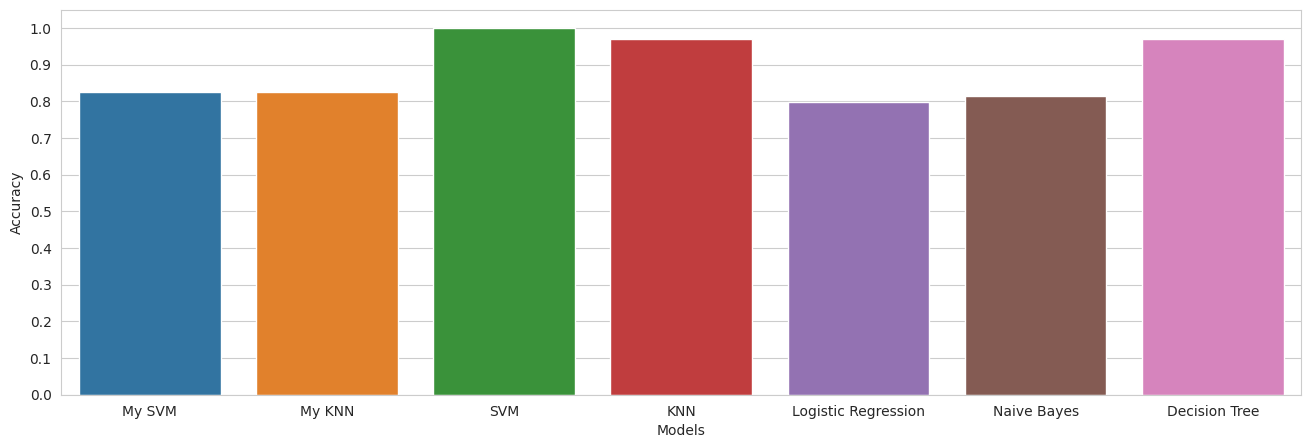

In [154]:
keeys, accs = zip(*list(accuracies.items()))

plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.2, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Models")
sns.barplot(x=np.array(keeys), y=np.array(accs))
plt.show()

Можно видеть, что библиотечные реализации показывают лучшую accuracy.

## Confusion Matrix

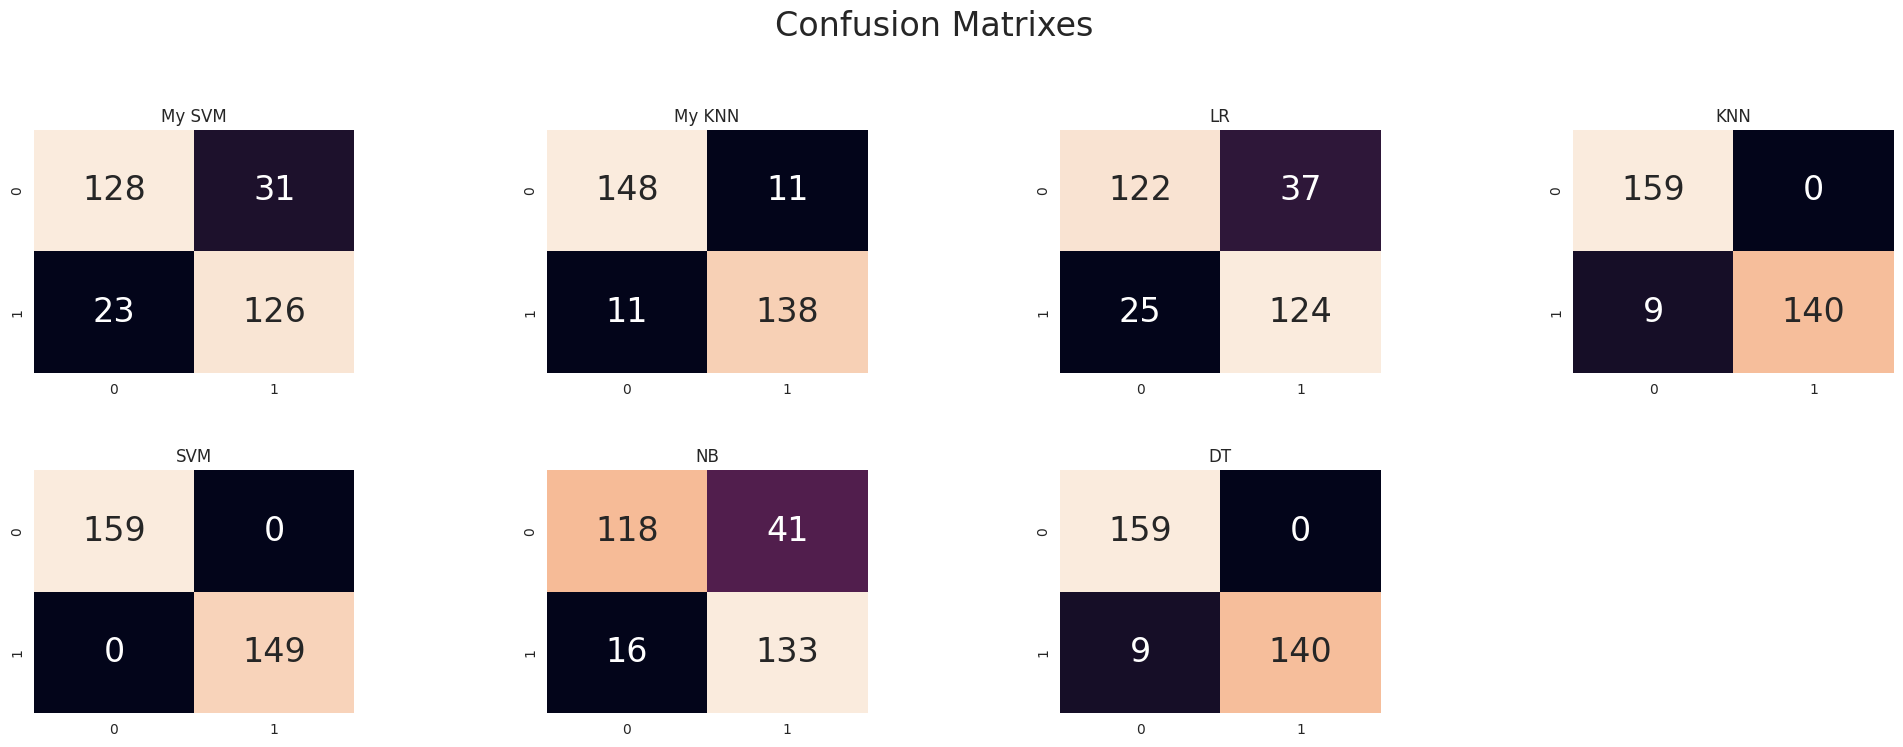

In [155]:
def cm(cl):
    return confusion_matrix(y_test, cl.predict(X_test_scaled))

plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

for idx, (name, cm) in enumerate([
    ("My SVM", cm(my_svm)),
    ("My KNN", cm(my_knn)),
    ("LR", cm(lr)),
    ("KNN", cm(knn)),
    ("SVM", cm(svm)),
    ("NB", cm(nb)),
    ("DT", cm(dtc))
]):
    plt.subplot(3, 4, idx+1)
    plt.title(name)
    sns.heatmap(cm,annot=True,fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы

Лучшее качество показали модели SVM, KNN и Decision Tree.
Собственная реализация KNN также показала нелохой результат.
Собственная реализация SVM уступает по качеству библиотечной, но показывает качество на уровне библиотечных LR и NB